In [130]:
import time
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, Dataset, DataLoader
from torchsummary import summary
from torchvision import transforms as T
from tensorflow import summary as tfsummary
import pickle
from sklearn.metrics import classification_report
from PIL import Image
from tqdm.auto import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [131]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


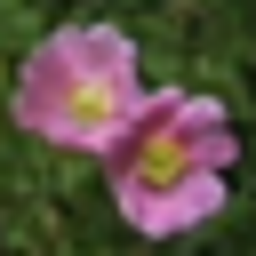

In [132]:
with open('cifar-100-python/train', 'rb') as f:
    data_train = pickle.load(f, encoding='latin1')
with open('cifar-100-python/test', 'rb') as f:
    data_test = pickle.load(f, encoding='latin1')

# Здесь указать ваши классы по варианту!!!
CLASSES = [19, 35, 70]

train_X = data_train['data'].reshape(-1, 3, 32, 32)
train_X = np.transpose(train_X, [0, 2, 3, 1]) # NCHW -> NHWC
train_y = np.array(data_train['fine_labels'])
mask = np.isin(train_y, CLASSES)
train_X = train_X[mask].copy()
train_y = train_y[mask].copy()
train_y = np.unique(train_y, return_inverse=1)[1]
del data_train

test_X = data_test['data'].reshape(-1, 3, 32, 32)
test_X = np.transpose(test_X, [0, 2, 3, 1])
test_y = np.array(data_test['fine_labels'])
mask = np.isin(test_y, CLASSES)
test_X = test_X[mask].copy()
test_y = test_y[mask].copy()
test_y = np.unique(test_y, return_inverse=1)[1]
del data_test
Image.fromarray(train_X[50]).resize((256,256))

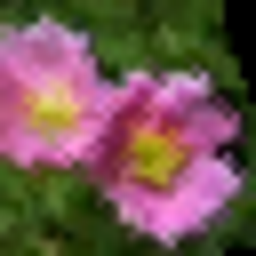

In [133]:
class CifarDataset(Dataset):
     def __init__(self, X, y, transform=None, p=0.0):
         assert X.size(0) == y.size(0)
         super(Dataset, self).__init__()
         self.X = X
         self.y = y
         self.transform = transform
         self.prob = p
        
     def __len__(self):
         return self.y.size(0)
        
     def __getitem__(self, index):
        x = self.X[index]
        if self.transform and np.random.random()<self.prob:
            x = self.transform(x.permute(2, 0, 1)/255.).permute(1, 2, 0)*255.
        y = self.y[index]
        return x, y

transform = T.Compose([
     T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.2, hue=0.0),
     T.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.8, 1.2),
                    shear=5),
])
#transform = T.AutoAugment(T.AutoAugmentPolicy.CIFAR10)

Image.fromarray((transform(torch.Tensor(train_X[50]).permute(2, 0, 1)/255.).\
                 permute(1, 2, 0).numpy()*255.).astype(np.uint8)).\
                 resize((256, 256))

In [134]:
batch_size = 128
dataloader = {}
for (X, y), part in zip([(train_X, train_y), (test_X, test_y)],
                        ['train', 'test']):
    tensor_x = torch.Tensor(X)
    tensor_y = F.one_hot(torch.Tensor(y).to(torch.int64),
                                     num_classes=len(CLASSES))/1.
    dataset = CifarDataset(tensor_x, tensor_y,
                           transform if part=='train' else None,
                           p=0.5) # создание объекта датасета
    dataloader[part] = DataLoader(dataset, batch_size=batch_size,
                                  prefetch_factor=8 if part=='train' else 2,
                                  num_workers=2, persistent_workers=True,
                                  shuffle=True) # создание экземпляра класса DataLoader
dataloader

{'train': <torch.utils.data.dataloader.DataLoader at 0x7f04b74fbf10>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7f03912698d0>}

In [135]:
class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.tensor(mean).to(device)
        self.std = torch.tensor(std).to(device)

    def forward(self, input):
        x = input / 255.0
        x = x - self.mean
        x = x / self.std
        return x.permute(0, 3, 1, 2) # nhwc -> nm

class GlobalMaxPool2d(nn.Module):
    def __init__(self):
        super(GlobalMaxPool2d, self).__init__()

    def forward(self, input):
        out = F.adaptive_max_pool2d(input, output_size=1)
        return out.flatten(start_dim=1)

class Cifar100_CNN(nn.Module):
    def __init__(self, hidden_size=32, classes=100):
        super(Cifar100_CNN, self).__init__()
        # https://blog.jovian.ai/image-classification-of-cifar100-dataset-using-pytorch-8b7145242df1
        self.seq = nn.Sequential(
            Normalize([0.5074,0.4867,0.4411],[0.2011,0.1987,0.2025]),
            # первый способ уменьшения размерности картинки - через stride
            nn.Conv2d(3, HIDDEN_SIZE, 5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(4),
            nn.Dropout2d(p=0.1),
            # второй способ уменьшения размерности картинки - через слой пуллинг
            nn.Conv2d(HIDDEN_SIZE, HIDDEN_SIZE*2, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.AvgPool2d(4),
            nn.Dropout2d(p=0.1),
            # nn.MaxPool2d(4),
            nn.Flatten(),
            nn.Linear(HIDDEN_SIZE*8, classes),
        )

    def forward(self, input):
        return self.seq(input)

HIDDEN_SIZE = 32 # в 4 раза больше параметров, чем у свёрточной модели из ЛР2 
model = Cifar100_CNN(hidden_size=HIDDEN_SIZE, classes=len(CLASSES))
# NEW
model.to(device)
print(model(torch.rand(1, 32, 32, 3).to(device)))
summary(model, input_size=(32, 32, 3))
model

tensor([[-0.1129, -0.0873,  0.0545]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Normalize-1            [-1, 3, 32, 32]               0
            Conv2d-2           [-1, 32, 32, 32]           2,432
              ReLU-3           [-1, 32, 32, 32]               0
         MaxPool2d-4             [-1, 32, 8, 8]               0
         Dropout2d-5             [-1, 32, 8, 8]               0
            Conv2d-6             [-1, 64, 8, 8]          18,496
              ReLU-7             [-1, 64, 8, 8]               0
         AvgPool2d-8             [-1, 64, 2, 2]               0
         Dropout2d-9             [-1, 64, 2, 2]               0
          Flatten-10                  [-1, 256]               0
           Linear-11                    [-1, 3]             771
Total params: 21,699
Trainable params: 21,699
Non-trainable params: 0
---------

Cifar100_CNN(
  (seq): Sequential(
    (0): Normalize()
    (1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (2): ReLU()
    (3): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout2d(p=0.1, inplace=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): AvgPool2d(kernel_size=4, stride=4, padding=0)
    (8): Dropout2d(p=0.1, inplace=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=256, out_features=3, bias=True)
  )
)

In [136]:
current_time = str(int(time.time()))
train_log_dir = 'logs/tensorboard/train/' + current_time
test_log_dir = 'logs/tensorboard/test/' + current_time
train_summary_writer = tfsummary.create_file_writer(train_log_dir)
test_summary_writer = tfsummary.create_file_writer(test_log_dir)

In [137]:
# добавляем сглаживание целевых меток, это увеличит значение функции потерь
# но полученная модель будет более устойчивой к выбросам в обучающей выборке
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
# используется SGD c momentum и L2-регуляризацией весов
optimizer = optim.SGD(model.parameters(), lr=3e-3, momentum=0.9,
                      weight_decay=1e-5)
# добавляем постепенное уменьшение шага обучения каждые 200 эпох
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=240, gamma=0.5)

In [138]:
%tensorboard --logdir logs/tensorboard

Reusing TensorBoard on port 6006 (pid 4094), started 0:39:06 ago. (Use '!kill 4094' to kill it.)

Эпоха: 500
Лучшая доля правильных ответов: 91.92708333333333
Текущая доля правильных ответов: 88.92045593261719


  0%|          | 0/6000 [00:00<?, ?it/s]

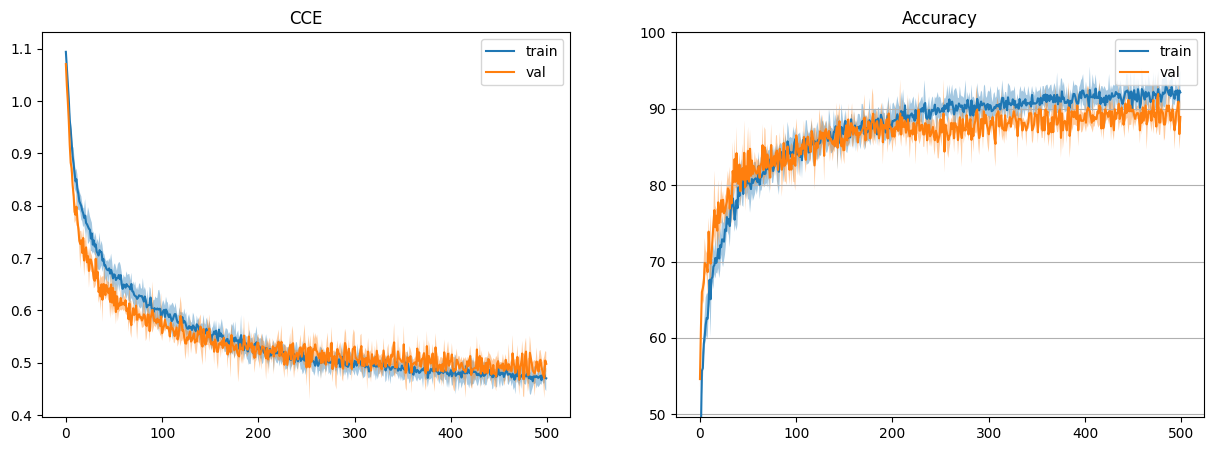

Обучение закончено за 101.0432813167572 секунд


In [139]:
EPOCHS = 500
REDRAW_EVERY = 20
steps_per_epoch = len(dataloader['train'])
steps_per_epoch_val = len(dataloader['test'])
# NEW
pbar = tqdm(total=EPOCHS*steps_per_epoch)
losses = []
losses_val = []
passed = 0
# для создания чекпоинта
best_acc = 0
checkpoint_path = 'cifar_cnn_aug.pth' 
for epoch in range(EPOCHS):  # проход по набору данных несколько раз
    tmp = []
    model.train()
    for i, batch in enumerate(dataloader['train'], 0):
        # получение одного минибатча; batch это двуэлементный список из [inputs, labels]
        inputs, labels = batch
        # на GPU
        inputs, labels = inputs.to(device), labels.to(device)

        # очищение прошлых градиентов с прошлой итерации
        optimizer.zero_grad()

        # прямой + обратный проходы + оптимизация
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        #loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()

        # для подсчёта статистик
        accuracy = (labels.detach().argmax(dim=-1)==outputs.detach().argmax(dim=-1)).\
                    to(torch.float32).mean().cpu()*100
        tmp.append((loss.item(), accuracy.item()))
        pbar.update(1)
        # запись в tensorboard
        with train_summary_writer.as_default():
            tfsummary.scalar('loss', tmp[-1][0], step=pbar.n)
            tfsummary.scalar('accuracy', tmp[-1][1], step=pbar.n)
    losses.append((np.mean(tmp, axis=0),
                   np.percentile(tmp, 25, axis=0),
                   np.percentile(tmp, 75, axis=0)))
    scheduler.step() # обновляем learning_rate каждую эпоху
    tmp = []
    model.eval()
    with torch.no_grad(): # отключение автоматического дифференцирования
        for i, data in enumerate(dataloader['test'], 0):
            inputs, labels = data
            # на GPU
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            accuracy = (labels.argmax(dim=-1)==outputs.argmax(dim=-1)).\
                        to(torch.float32).mean().cpu()*100
            tmp.append((loss.item(), accuracy.item()))
    losses_val.append((np.mean(tmp, axis=0),
                       np.percentile(tmp, 25, axis=0),
                       np.percentile(tmp, 75, axis=0)))
    # запись в tensorboard
    with test_summary_writer.as_default():
        tfsummary.scalar('loss', losses_val[-1][0][0], step=pbar.n)
        tfsummary.scalar('accuracy', losses_val[-1][0][1], step=pbar.n)
    # сохранение чекпоинта
    acc = losses_val[-1][0][1]
    if acc > best_acc:
        best_acc = acc
        torch.save(model.state_dict(), checkpoint_path)
    # обновление графиков
    if (epoch+1) % REDRAW_EVERY != 0:
        continue
    clear_output(wait=False)
    print('Эпоха: %s\n'
          'Лучшая доля правильных ответов: %s\n'
          'Текущая доля правильных ответов: %s' % (epoch+1, best_acc, acc))
    passed += pbar.format_dict['elapsed']
    pbar = tqdm(total=EPOCHS*steps_per_epoch, miniters=5)
    pbar.update((epoch+1)*steps_per_epoch)
    x_vals = np.arange(epoch+1)
    _, ax = plt.subplots(1, 2, figsize=(15, 5))
    stats = np.array(losses)
    stats_val = np.array(losses_val)
    ax[1].set_ylim(stats_val[:, 0, 1].min()-5, 100)
    ax[1].grid(axis='y')
    for i, title in enumerate(['CCE', 'Accuracy']):
        ax[i].plot(x_vals, stats[:, 0, i], label='train')
        ax[i].fill_between(x_vals, stats[:, 1, i],
                           stats[:, 2, i], alpha=0.4)
        ax[i].plot(x_vals, stats_val[:, 0, i], label='val')
        ax[i].fill_between(x_vals,
                           stats_val[:, 1, i],
                           stats_val[:, 2, i], alpha=0.4)
        ax[i].legend()
        ax[i].set_title(title)
    plt.show()
model.load_state_dict(torch.load(checkpoint_path))
print('Обучение закончено за %s секунд' % passed)

In [140]:
batch_size = 128
dataloader = {}
for (X, y), part in zip([(train_X, train_y), (test_X, test_y)],
                        ['train', 'test']):
    tensor_x = torch.Tensor(X)
    tensor_y = F.one_hot(torch.Tensor(y).to(torch.int64),
                                     num_classes=len(CLASSES))/1.
    dataset = CifarDataset(tensor_x, tensor_y,
                           transform=None,
                           p=0.0) # создание объекта датасета
    dataloader[part] = DataLoader(dataset, batch_size=batch_size,
                                  num_workers=2, shuffle=True) # создание экземпляра класса DataLoader
dataloader

{'train': <torch.utils.data.dataloader.DataLoader at 0x7f04b9c8fc70>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7f04b7251960>}

In [141]:
for part in ['train', 'test']:
    y_pred = []
    y_true = []
    with torch.no_grad(): # отключение автоматического дифференцирования
        for i, data in enumerate(dataloader[part], 0):
            inputs, labels = data
             # на GPU
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs).detach().cpu().numpy()
            y_pred.append(outputs)
            y_true.append(labels.cpu().numpy())
        y_true = np.concatenate(y_true)
        y_pred = np.concatenate(y_pred)
        print(part)
        print(classification_report(y_true.argmax(axis=-1), y_pred.argmax(axis=-1),
                                    digits=4, target_names=list(map(str, CLASSES))))
        print('-'*50)

train
              precision    recall  f1-score   support

          19     0.9563    0.9620    0.9591       500
          35     0.9387    0.9500    0.9443       500
          70     0.9857    0.9680    0.9768       500

    accuracy                         0.9600      1500
   macro avg     0.9602    0.9600    0.9601      1500
weighted avg     0.9602    0.9600    0.9601      1500

--------------------------------------------------
test
              precision    recall  f1-score   support

          19     0.9000    0.9000    0.9000       100
          35     0.8476    0.8900    0.8683       100
          70     0.9474    0.9000    0.9231       100

    accuracy                         0.8967       300
   macro avg     0.8983    0.8967    0.8971       300
weighted avg     0.8983    0.8967    0.8971       300

--------------------------------------------------


In [142]:
# # входной тензор для модели
# x = torch.randn(1, 32, 32, 3, requires_grad=True).to(device)
# torch_out = model(x)

# # экспорт модели
# torch.onnx.export(model,               # модель
#                   x,                   # входной тензор (или кортеж нескольких тензоров)
#                   "CNN_AUG.onnx", # куда сохранить (либо путь к файлу либо fileObject)
#                   export_params=True,  # сохраняет веса обученных параметров внутри файла модели
#                   opset_version=9,     # версия ONNX
#                   do_constant_folding=True,  # следует ли выполнять укорачивание констант для оптимизации
#                   input_names = ['input'],   # имя входного слоя
#                   output_names = ['output'],  # имя выходного слоя
#                   dynamic_axes={'input' : {0 : 'batch_size'},    # динамичные оси, в данном случае только размер пакета
#                                 'output' : {0 : 'batch_size'}})